<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-original-subsets:-train,-test-and-split-or..." data-toc-modified-id="load-original-subsets:-train,-test-and-split-or...-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load original subsets: train, test and split or...</a></span></li><li><span><a href="#...load-my-subsets:-train,-dev,-test" data-toc-modified-id="...load-my-subsets:-train,-dev,-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>...load my subsets: train, dev, test</a></span></li><li><span><a href="#Neural-net-to-make-predictions-or..." data-toc-modified-id="Neural-net-to-make-predictions-or...-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Neural net to make predictions or...</a></span><ul class="toc-item"><li><span><a href="#train-th-model-or..." data-toc-modified-id="train-th-model-or...-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>train th model or...</a></span></li><li><span><a href="#...load-a-pretrained-one" data-toc-modified-id="...load-a-pretrained-one-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>...load a pretrained one</a></span></li><li><span><a href="#make-predictions" data-toc-modified-id="make-predictions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>make predictions</a></span></li></ul></li><li><span><a href="#...load-mlp-probs-or..." data-toc-modified-id="...load-mlp-probs-or...-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>...load mlp probs or...</a></span></li><li><span><a href="#...load-LabelPowerset-probs" data-toc-modified-id="...load-LabelPowerset-probs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>...load LabelPowerset probs</a></span></li><li><span><a href="#Static-thresholds" data-toc-modified-id="Static-thresholds-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Static thresholds</a></span></li><li><span><a href="#SGLThresh" data-toc-modified-id="SGLThresh-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SGLThresh</a></span><ul class="toc-item"><li><span><a href="#SurrogateHeaviside-definition" data-toc-modified-id="SurrogateHeaviside-definition-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>SurrogateHeaviside definition</a></span></li><li><span><a href="#SurrogateHeaviside-definition-thresh-and-sigma-learnable" data-toc-modified-id="SurrogateHeaviside-definition-thresh-and-sigma-learnable-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>SurrogateHeaviside definition thresh and sigma learnable</a></span></li><li><span><a href="#numerical-application" data-toc-modified-id="numerical-application-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>numerical application</a></span></li><li><span><a href="#numerical-application,-for-loop" data-toc-modified-id="numerical-application,-for-loop-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>numerical application, for loop</a></span></li></ul></li><li><span><a href="#NumThresh" data-toc-modified-id="NumThresh-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>NumThresh</a></span><ul class="toc-item"><li><span><a href="#utility-function" data-toc-modified-id="utility-function-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>utility function</a></span></li><li><span><a href="#numerical-application" data-toc-modified-id="numerical-application-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>numerical application</a></span></li></ul></li></ul></div>

# imports

In [22]:
# paper http://lpis.csd.auth.gr/publications/tsoumakas-ismir08.pdf
# !pip install requests
# !pip install scikit-multilearn
#!pip install skorch
#!pip install liac-arff
# !pip install jupyter_contrib_nbextensions

In [66]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
# from skorch import NeuralNetClassifier

In [67]:
import numpy as np
import sklearn.metrics as metrics
from skmultilearn.dataset import load_dataset
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split


In [3]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
def predict(mydataloader, y, model):
    model.eval()

    all_outputs = torch.zeros_like(y)

    for i_batch, sample_batched in enumerate(mydataloader):

        X_batch, y_batch = sample_batched
        outputs = model(X_batch)
        B = X_batch.size()[0]
        all_outputs[i_batch*B:(i_batch+1)*B]=outputs
    return all_outputs


def print_thresholds(thresh, nb_classes):
    s = ''
    for c in range(nb_classes):
        s+='%.4f '%thresh[c]
    print("auto_thresholds", s)

    
def compute_instance_F1(gt_y, preds):
    num = gt_y*preds
    num = 2*np.sum(num, axis=1)
    den = np.sum(gt_y, axis=1) + np.sum(preds, axis=1)
    return np.mean(num/den)


def unit_test(gt_y, preds):
    print("%.2f"%compute_instance_F1(gt_y, preds))

    
def print_scores(gt_y, preds):
    print(classification_report(gt_y, preds, digits=3))    
    set_accuracy = accuracy_score(gt_y, preds)
    print('set acc: %.3f'%(set_accuracy))

    
def micro_prec_rec_fscore(gt_y, preds):
    prec, rec, fscore, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='micro')
    return prec, rec, fscore


def micro_prec_rec_fscore_class(gt_y, preds):
    prec, rec, fscore, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average=None)
    return prec, rec, fscore
    
# def print_scores(gt_y, preds):
#     p2, r2, fscore2, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='micro')
#     p3, r3, fscore3, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='macro')
#     set_accuracy = accuracy_score(gt_y, preds)
#     print('micro: p:%.2f r:%.2f f1:%.2f'%(100.*p2, 100.*r2, 100.*fscore2))
#     print('macro: p:%.2f r:%.2f f1:%.2f'%(100.*p3, 100.*r3, 100.*fscore3))
#     print('set acc:%.2f instance-F1:%.2f'%(100.*set_accuracy, 100*compute_instance_F1(gt_y, preds)))
    
def compute_accuracy_from_numpy_tensors(gt_y_numpy, preds_numpy):
    acc_per_class = sum(gt_y_numpy==preds_numpy)/len(gt_y_numpy)
    
    gt_y_numpy_vec = np.reshape(gt_y_numpy, -1)
    preds_numpy_vec = np.reshape(preds_numpy, -1)
    acc = sum(gt_y_numpy_vec==preds_numpy_vec)/len(gt_y_numpy_vec)
    print("Acc per class:", acc_per_class)
    print("Acc: %.3f"%acc)


dummy_y = np.array([[1,0,0], [0,1,0]])
dummy_preds = np.array([[1,0,0], [0,0,0]])
unit_test(dummy_y, dummy_preds)

0.50


# load original subsets: train, test and split or...

In [5]:
nb_classes=6
dataset = 'emotions'
X_train, y_train, feature_names, label_names = load_dataset('emotions', 'train')
X_test, y_test, _, _ = load_dataset('emotions', 'test')

X_train_numpy = X_train.toarray()
X_test_numpy = X_test.toarray()
y_train_numpy = y_train.toarray()
y_test_numpy = y_test.toarray()

emotions:train - exists, not redownloading
emotions:test - exists, not redownloading


In [18]:
X_train_numpy, X_dev_numpy, y_train_numpy, y_dev_numpy = train_test_split(
    X_train_numpy, y_train_numpy, test_size=0.33, random_state=42)


In [19]:
X_train_numpy.shape, y_train_numpy.shape, X_dev_numpy.shape, y_dev_numpy.shape

((261, 72), (261, 6), (130, 72), (130, 6))

In [10]:
# np.savez("datasets/emotions/%s_train_dev_test.npz"%dataset, 
#          X_train_numpy=X_train_numpy, 
#          X_dev_numpy = X_dev_numpy,
#          X_test_numpy = X_test_numpy,
#          y_train_numpy=y_train_numpy, 
#          y_dev_numpy = y_dev_numpy,
#          y_test_numpy = y_test_numpy)

# ...load my subsets: train, dev, test

In [6]:
nb_classes=6
dataset = 'emotions'

arr = np.load("datasets/emotions/%s_train_dev_test.npz"%dataset)
# print(arr["train_proba"])

X_train_numpy = arr["X_train_numpy"]
X_dev_numpy = arr['X_dev_numpy']
X_test_numpy = arr['X_test_numpy']
y_train_numpy = arr['y_train_numpy']
y_dev_numpy = arr['y_dev_numpy']
y_test_numpy = arr['y_test_numpy']
                
X_train_numpy.shape, X_dev_numpy.shape, X_test_numpy.shape, y_train_numpy.shape, y_dev_numpy.shape, y_test_numpy.shape

((261, 72), (130, 72), (202, 72), (261, 6), (130, 6), (202, 6))

In [7]:
X_train_pth = torch.tensor(X_train_numpy, dtype=torch.float)
X_dev_pth = torch.tensor(X_dev_numpy, dtype=torch.float)
X_test_pth = torch.tensor(X_test_numpy, dtype=torch.float)

y_train_pth = torch.tensor(y_train_numpy, dtype=torch.float)
y_dev_pth = torch.tensor(y_dev_numpy, dtype=torch.float)
y_test_pth = torch.tensor(y_test_numpy, dtype=torch.float)

In [8]:
X_train_pth.size(), y_train_pth.size(), y_train_pth[:2]

(torch.Size([261, 72]),
 torch.Size([261, 6]),
 tensor([[1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 1.]]))

# Neural net to make predictions or...

In [9]:
input_dim = X_train_pth.size()[1]
hidden_dim = 200
# output_dim = len(np.unique(y_train.rows))
output_dim = 6
input_dim, hidden_dim, output_dim 

(72, 200, 6)

In [10]:
train_dataset = data.TensorDataset(X_train_pth, y_train_pth) # create your datset
train_dataloader = data.DataLoader(train_dataset, batch_size=6, shuffle=True)

dev_dataset = data.TensorDataset(X_dev_pth, y_dev_pth) # create your datset
dev_dataloader = data.DataLoader(dev_dataset, batch_size=32, shuffle=False)

test_dataset = data.TensorDataset(X_test_pth, y_test_pth) # create your datset
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class MultiClassClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(MultiClassClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = self.output(X)
#         X = F.softmax(X, dim=-1)
        X = torch.sigmoid(X)

        return X

In [56]:
model = MultiClassClassifierModule(input_dim, hidden_dim, output_dim)

criterion = torch.nn.BCELoss(reduction="mean")
# criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MultiClassClassifierModule(
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden): Linear(in_features=72, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=6, bias=True)
)


## train the model or...

In [57]:
num_epochs = 10


losses = []
for epoch in range(num_epochs):
    
    debut = time.time()
    model.train()
    
    for i_batch, sample_batched in enumerate(train_dataloader):
        
        X_batch, y_batch = sample_batched
        
#         print(i_batch, X_batch.size(), y_batch.size())
    
        # Forward pass
        # inputs:  predictions_tensor
        outputs = model(X_batch)
#         print(outputs.size())
    #     if epoch % 10 == 0:
    #         print(outputs[-1])
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss)
    
    duree_epoch = time.time() - debut

    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, num_epochs, loss, duree_epoch))

Epoch [1/10], Loss: 1.7900, Duration: 0.1 s
Epoch [2/10], Loss: 1.2442, Duration: 0.1 s
Epoch [3/10], Loss: 0.6144, Duration: 0.1 s
Epoch [4/10], Loss: 0.6727, Duration: 0.0 s
Epoch [5/10], Loss: 0.5096, Duration: 0.1 s
Epoch [6/10], Loss: 0.4942, Duration: 0.1 s
Epoch [7/10], Loss: 0.6054, Duration: 0.0 s
Epoch [8/10], Loss: 0.4968, Duration: 0.1 s
Epoch [9/10], Loss: 0.4969, Duration: 0.1 s
Epoch [10/10], Loss: 0.7386, Duration: 0.1 s


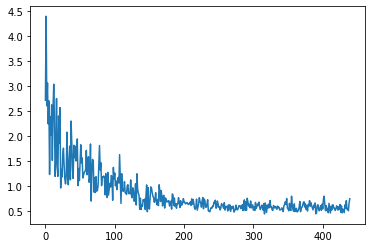

In [58]:
plt.plot(losses)

In [ ]:
# torch.save(model.state_dict(), "exp/emotions/21_03_2020/mlp_%s.pth"%dataset)

## ...load a pretrained one

In [51]:
model.load_state_dict(torch.load("exp/emotions/21_03_2020/mlp_%s.pth"%dataset))
model.eval()

MultiClassClassifierModule(
  (dropout): Dropout(p=0.5)
  (hidden): Linear(in_features=72, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=6, bias=True)
)

## make predictions

In [60]:
train_outputs = predict(train_dataloader, y_train_pth, model)
dev_outputs = predict(dev_dataloader, y_dev_pth, model)
test_outputs = predict(test_dataloader, y_test_pth, model)

train_outputs_numpy = train_outputs.clone().detach().cpu().numpy()
dev_outputs_numpy = dev_outputs.clone().detach().cpu().numpy()
test_outputs_numpy = test_outputs.clone().detach().cpu().numpy()
# y_test[:5], test_outputs[:5]

In [37]:
# # !mkdir exp/emotions/21_03_2020
# np.savez("exp/emotions/21_03_2020/mlp_probs_%s_train_dev_test.npz"%dataset, 
#          train_outputs_numpy=train_outputs_numpy,
#          dev_outputs_numpy = dev_outputs_numpy,
#          test_outputs_numpy=test_outputs_numpy)

mkdir: cannot create directory ‘exp/emotions/21_03_2020’: File exists


In [35]:
# np.savez("exp/emotions/mlp/%s_MLP_train_test_proba.npz"%dataset, train_proba=train_outputs_numpy, test_proba=test_outputs_numpy)

# ...load mlp probs or...

In [38]:
arr = np.load("exp/emotions/21_03_2020/mlp_probs_%s_train_dev_test.npz"%dataset)

train_outputs_numpy = arr["train_outputs_numpy"]
dev_outputs_numpy = arr["dev_outputs_numpy"]
test_outputs_numpy = arr["test_outputs_numpy"]
train_outputs_numpy.shape, dev_outputs_numpy.shape, test_outputs_numpy.shape

((261, 6), (130, 6), (202, 6))

In [9]:
# arr = np.load("exp/emotions/mlp/%s_MLP_train_test_proba.npz"%dataset)
# # print(arr["train_proba"])

# train_outputs_numpy = arr["train_proba"]
# test_outputs_numpy = arr["test_proba"]
# train_outputs_numpy.shape, test_outputs_numpy.shape

((391, 6), (202, 6))

# ...load SVM-BR probs

In [215]:
arr = np.load("exp/emotions/SVM_BR_probs.npz")
# print(arr["train_proba"])

train_outputs_numpy = arr["svm_train_prob"]
dev_outputs_numpy = arr["svm_dev_prob"]
test_outputs_numpy = arr["svm_test_prob"]

train_outputs_numpy.shape, dev_outputs_numpy.shape, test_outputs_numpy.shape

((261, 6), (130, 6), (202, 6))

# ...load LabelPowerset probs

In [9]:
arr = np.load("datasets/emotions/emotions_LabelPowerset_train_test_proba.npz")
# print(arr["train_proba"])

train_outputs_numpy = arr["train_proba"]
test_outputs_numpy = arr["test_proba"]
train_outputs_numpy.shape, test_outputs_numpy.shape

((391, 6), (202, 6))

# Static thresholds

In [149]:
static_thresh = 0.3
train_pred = train_outputs_numpy>static_thresh
dev_pred = dev_outputs_numpy>static_thresh
test_pred = test_outputs_numpy>static_thresh

In [150]:
print("train")
print_scores(y_train_numpy, train_pred)
print("dev")
print_scores(y_dev_numpy, dev_pred)
print("test")
print_scores(y_test_numpy, test_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)

train
              precision    recall  f1-score   support

           0      0.697     0.864     0.772        88
           1      0.622     0.708     0.662        72
           2      0.712     0.952     0.815       104
           3      0.809     0.948     0.873        58
           4      0.783     0.770     0.777        61
           5      0.661     0.902     0.763        82

   micro avg      0.705     0.865     0.777       465
   macro avg      0.714     0.858     0.777       465
weighted avg      0.708     0.865     0.776       465
 samples avg      0.723     0.863     0.758       465

set acc: 0.372
dev
              precision    recall  f1-score   support

           0      0.434     0.742     0.548        31
           1      0.370     0.486     0.420        35
           2      0.713     0.891     0.792        64
           3      0.750     0.871     0.806        31
           4      0.452     0.559     0.500        34
           5      0.683     0.837     0.752        49

## plot asof threshold

/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text yticklabel objects>)

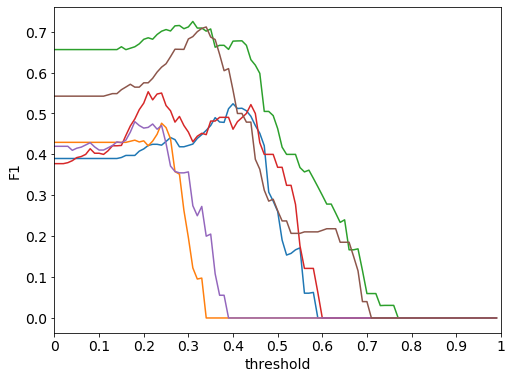

In [61]:
ps, rs, f1s = [], [], []

for static_thresh in range(0, 100):
    static_thresh /= 100.
    train_pred = train_outputs_numpy>static_thresh
    dev_pred = dev_outputs_numpy>static_thresh
    test_pred = test_outputs_numpy>static_thresh

    # p, r, f1 = micro_prec_rec_fscore(y_dev_numpy, dev_pred)
    p, r, f1 = micro_prec_rec_fscore_class(y_dev_numpy, dev_pred)
    ps.append(p)
    rs.append(r)
    f1s.append(f1)

f1s = np.array(f1s)

fontsize=14
linewidth=2
plt.figure(figsize=(8,6))
for ind in range(f1s[0].shape[0]):
    plt.plot(f1s[:,ind], label='%d'%ind)

# plt.plot([23, 23], [0, 0.6], '-k')
plt.xlabel("threshold", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xlim([0,100])
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.legend(fontsize=fontsize, loc='upper right')
# plt.savefig("exp/emotions/emotions_F1_DEV_asof_threshold.png")
# plt.savefig("exp/emotions/emotions_F1_DEV_asof_threshold.eps")

In [52]:
manual_thresh = [0.39, 0.24, 0.35, 0.23, 0.23, 0.23]
train_pred = train_outputs_numpy>manual_thresh
dev_pred = dev_outputs_numpy>manual_thresh
test_pred = test_outputs_numpy>manual_thresh

In [53]:
print("train")
print_scores(y_train_numpy, train_pred)
print("dev")
print_scores(y_dev_numpy, dev_pred)
print("test")
print_scores(y_test_numpy, test_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)

train
              precision    recall  f1-score   support

           0      0.289     0.295     0.292        88
           1      0.259     0.694     0.377        72
           2      0.393     0.673     0.496       104
           3      0.176     0.414     0.247        58
           4      0.174     0.393     0.241        61
           5      0.297     0.537     0.383        82

   micro avg      0.270     0.512     0.353       465
   macro avg      0.265     0.501     0.340       465
weighted avg      0.280     0.512     0.355       465
 samples avg      0.266     0.511     0.335       465

set acc: 0.008
dev
              precision    recall  f1-score   support

           0      0.513     0.645     0.571        31
           1      0.319     0.829     0.460        35
           2      0.582     0.891     0.704        64
           3      0.348     0.742     0.474        31
           4      0.362     0.735     0.485        34
           5      0.612     0.837     0.707        49

/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SGLThresh

## SurrogateHeaviside definition

In [123]:
# device = 'cpu'

class SurrogateHeaviside(torch.autograd.Function):
    
    # Activation function with surrogate gradient
#     sigma = 100.0

    @staticmethod 
    def forward(ctx, input, sigma):
        
        output = torch.zeros_like(input)
        output[input > 0] = 1.0
        ctx.save_for_backward(input, sigma)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        
        input, sigma = ctx.saved_tensors
        grad_input = grad_output.clone()
        # approximation of the gradient using sigmoid function
        grad = grad_input*torch.sigmoid(sigma*input)*torch.sigmoid(-sigma*input)
        
        grad_sigma = None
        
        return grad, grad_sigma

threshold_fn = SurrogateHeaviside.apply


class ThresholdModel(nn.Module):
    def __init__(self, threshold_fn, t=0.5, nb_classes=10):
        super(ThresholdModel, self).__init__()
        
        # define nb_classes seuils differents, initialisés à 0.5

#         self.dense = torch.nn.Linear(10, 10)

        self.thresh = torch.nn.Parameter(t*torch.ones(nb_classes), requires_grad=True)
        self.threshold_fn = threshold_fn
        
    
    def forward(self, x, sigma):
        out = self.threshold_fn(x.to(device, dtype=torch.float)-self.thresh.to(device, dtype=torch.float), sigma)
#         out = out.clamp_(min=0.01, max=0.99)
        # out = self.dense(x.to(device, dtype=torch.float))
        # out = F.sigmoid(out)
        # out = self.threshold_fn(out-F.sigmoid(self.thresh.to(device, dtype=torch.float)))
        return out

    
    def clamp(self):
        
        self.thresh.data.clamp_(min=0., max=1.)

        
def F1_loss_objective(binarized_output, y_true):
    # let's first convert binary vector prob into logits
#     prob = torch.clamp(prob, 1.e-12, 0.9999999)
    
#     average = 'macro'
    average = 'micro'
    epsilon = torch.tensor(1e-12)
    
    if average == 'micro':
        y_true = torch.flatten(y_true)
        binarized_output = torch.flatten(binarized_output)
        
    true_positives = torch.sum(y_true * binarized_output, dim=0)
    predicted_positives = torch.sum(binarized_output, dim=0)
    positives = torch.sum(y_true, dim=0)
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (positives + epsilon)

    f1 = 2 * ((precision * recall) / (precision + recall + epsilon))
#     return precision, recall, f1
    return - f1.mean()
    

## SurrogateHeaviside definition thresh and sigma learnable

In [124]:
# device = 'cpu'

class SurrogateHeaviside(torch.autograd.Function):
    
    # Activation function with surrogate gradient
#     sigma = 100.0

    @staticmethod 
    def forward(ctx, input, sigma):
        
        output = torch.zeros_like(input)
        output[input > 0] = 1.0
        ctx.save_for_backward(input, sigma)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, sigma = ctx.saved_tensors
        grad_input = grad_output.clone()
        # approximation of the gradient using sigmoid function
        grad = grad_input*torch.sigmoid(sigma*input)*torch.sigmoid(-sigma*input)
        
        grad_sigma = grad_input*input*torch.sigmoid(sigma*input)*torch.sigmoid(-sigma*input)
        
        return grad, grad_sigma

threshold_fn = SurrogateHeaviside.apply


class ThresholdModel(nn.Module):
    def __init__(self, threshold_fn, t=0.5, sigma=100., nb_classes=10):
        super(ThresholdModel, self).__init__()
        
        # define nb_classes seuils differents, initialisés à 0.5

#         self.dense = torch.nn.Linear(10, 10)

        self.thresh = torch.nn.Parameter(t*torch.ones(nb_classes), requires_grad=True)
        self.sigma = torch.nn.Parameter(sigma*torch.ones(nb_classes), requires_grad=True)
        self.threshold_fn = threshold_fn
        
    
    def forward(self, x):
        out = self.threshold_fn(x.to(device, dtype=torch.float)-self.thresh.to(device, dtype=torch.float), 
                                self.sigma.to(device, dtype=torch.float))
#         out = out.clamp_(min=0.01, max=0.99)
        # out = self.dense(x.to(device, dtype=torch.float))
        # out = F.sigmoid(out)
        # out = self.threshold_fn(out-F.sigmoid(self.thresh.to(device, dtype=torch.float)))
        return out

    
    def clamp(self):
        
        self.thresh.data.clamp_(min=0., max=1.)

        
def F1_loss_objective(binarized_output, y_true):
    # let's first convert binary vector prob into logits
#     prob = torch.clamp(prob, 1.e-12, 0.9999999)
    
#     average = 'macro'
    average = 'micro'
    epsilon = torch.tensor(1e-12)
    
    if average == 'micro':
        y_true = torch.flatten(y_true)
        binarized_output = torch.flatten(binarized_output)
        
    true_positives = torch.sum(y_true * binarized_output, dim=0)
    predicted_positives = torch.sum(binarized_output, dim=0)
    positives = torch.sum(y_true, dim=0)
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (positives + epsilon)

    f1 = 2 * ((precision * recall) / (precision + recall + epsilon))
#     return precision, recall, f1
    return - f1.mean()
    

## numerical application

In [125]:
pth_train_probs = torch.tensor(train_outputs_numpy, dtype=torch.float).to(device)
pth_dev_probs = torch.tensor(dev_outputs_numpy, dtype=torch.float).to(device)
pth_test_probs = torch.tensor(test_outputs_numpy, dtype=torch.float).to(device)


pth_train_gt = y_train_pth.to(device, dtype=torch.float)
pth_dev_gt = y_dev_pth.to(device, dtype=torch.float)
pth_test_gt = y_test_pth.to(device, dtype=torch.float)

In [25]:
# from torch.optim.lr_scheduler import MultiStepLR


In [230]:
THRESHmodel = ThresholdModel(threshold_fn=threshold_fn, t=0.3, sigma=1., nb_classes=nb_classes)
THRESHmodel = THRESHmodel.to(device, dtype=torch.float)
# criterion = torch.nn.BCELoss(reduction="mean")
criterion = F1_loss_objective

learning_rate = 1e-3
# THRESHoptimizer = torch.optim.Adam(THRESHmodel.parameters(), lr=learning_rate)

# # learn only the thresholds:
THRESHoptimizer = torch.optim.Adam([
                {'params': THRESHmodel.thresh}
            ], lr=learning_rate)

# # learn the thresholds and sigma:
# THRESHoptimizer = torch.optim.Adam([
#                 {'params': THRESHmodel.thresh},
#                 {'params': THRESHmodel.sigma, 'lr': 1e-2}
#             ], lr=learning_rate)

# scheduler = MultiStepLR(THRESHoptimizer, milestones=[180], gamma=0.1)

Epoch [1/72], Loss: -0.6560, Duration: 0.0 s
threshs: tensor([1., 1., 1., 1., 1., 1.])
Epoch [2/72], Loss: -0.6548, Duration: 0.0 s
Epoch [3/72], Loss: -0.6548, Duration: 0.0 s
Epoch [4/72], Loss: -0.6536, Duration: 0.0 s
Epoch [5/72], Loss: -0.6536, Duration: 0.0 s
Epoch [6/72], Loss: -0.6572, Duration: 0.0 s
Epoch [7/72], Loss: -0.6548, Duration: 0.0 s
Epoch [8/72], Loss: -0.6548, Duration: 0.0 s
Epoch [9/72], Loss: -0.6536, Duration: 0.0 s
Epoch [10/72], Loss: -0.6512, Duration: 0.0 s
Epoch [11/72], Loss: -0.6571, Duration: 0.0 s
threshs: tensor([1., 1., 1., 1., 1., 1.])
Epoch [12/72], Loss: -0.6571, Duration: 0.0 s
Epoch [13/72], Loss: -0.6583, Duration: 0.0 s
Epoch [14/72], Loss: -0.6583, Duration: 0.0 s
Epoch [15/72], Loss: -0.6595, Duration: 0.0 s
Epoch [16/72], Loss: -0.6571, Duration: 0.0 s
Epoch [17/72], Loss: -0.6559, Duration: 0.0 s
Epoch [18/72], Loss: -0.6559, Duration: 0.0 s
Epoch [19/72], Loss: -0.6571, Duration: 0.0 s
Epoch [20/72], Loss: -0.6547, Duration: 0.0 s
Epoch

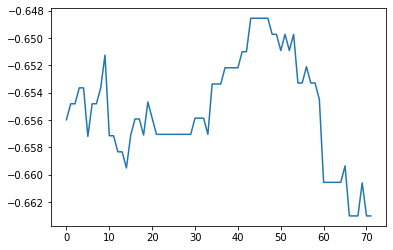

In [231]:
# Train the model, in batch mode
# num_epochs = 200
num_epochs = 72

# sigma = torch.nn.Parameter(torch.tensor(40.0), requires_grad=True)

cumul_delta_thresh = torch.zeros(nb_classes,)
delta_thresh = torch.zeros(nb_classes,)

for el in THRESHmodel.parameters():
    PREC_learned_AT_thresholds = el.clone().detach().cpu()

losses = []
for epoch in range(num_epochs):
    
    debut = time.time()
    
    THRESHmodel.train()
    
    # Forward pass
    # inputs:  predictions_tensor
#     outputs = THRESHmodel(pth_train_probs)
    outputs = THRESHmodel(pth_dev_probs)
    
#     if epoch % 10 == 0:
#         print(outputs[-1])
#     loss = criterion(outputs, pth_train_gt)
    loss = criterion(outputs, pth_dev_gt)

    # Backward and optimize
    THRESHoptimizer.zero_grad()

    loss.backward()
#     loss.mean().backward()
#         loss.backward(at_batch_y)
    # loss.backward(torch.ones_like(loss))
    
#     scheduler.step()
    
    THRESHoptimizer.step()
    # THRESHmodel.clamp()
    losses.append(loss)
    
    duree_epoch = time.time() - debut

#     print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
#            .format(epoch+1, num_epochs, loss.mean(), duree_epoch))
    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, num_epochs, loss, duree_epoch))

    for el in THRESHmodel.parameters():
        learned_AT_thresholds = el.clone().detach().cpu()

    delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
    cumul_delta_thresh += delta_thresh
    PREC_learned_AT_thresholds = learned_AT_thresholds
    if epoch % 10 == 0: print('threshs:', learned_AT_thresholds)
    # if torch.sum(delta_thresh) < 0.01: break
    
print('delta:', cumul_delta_thresh)
plt.figure()
# plt.figure(figsize=(8,6))
plt.plot(losses)

In [232]:
learned_AT_thresholds=THRESHmodel.thresh.clone().detach().cpu().numpy()
sigma = THRESHmodel.sigma.clone().detach().cpu().numpy()
learned_AT_thresholds, sigma

(array([0.37202796, 0.37200034, 0.22781925, 0.37181342, 0.37193185,
        0.22792256], dtype=float32),
 array([1., 1., 1., 1., 1., 1.], dtype=float32))

In [233]:
print_thresholds(learned_AT_thresholds, nb_classes)
train_pred = train_outputs_numpy>learned_AT_thresholds
dev_pred = dev_outputs_numpy>learned_AT_thresholds
test_pred = test_outputs_numpy>learned_AT_thresholds
print('train')
print_scores(y_train_numpy, train_pred)
# compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
print('dev')
print_scores(y_dev_numpy, dev_pred)
print('test')
print_scores(y_test_numpy, test_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)
# 0.3366 0.2834 0.2761 0.3185 0.2849 0.2611 

auto_thresholds 0.3720 0.3720 0.2278 0.3718 0.3719 0.2279 
train
              precision    recall  f1-score   support

           0      0.765     0.852     0.806        88
           1      0.735     0.500     0.595        72
           2      0.573     0.981     0.723       104
           3      0.900     0.931     0.915        58
           4      0.840     0.689     0.757        61
           5      0.500     0.963     0.658        82

   micro avg      0.654     0.834     0.733       465
   macro avg      0.719     0.819     0.743       465
weighted avg      0.697     0.834     0.736       465
 samples avg      0.672     0.843     0.720       465

set acc: 0.295
dev
              precision    recall  f1-score   support

           0      0.455     0.645     0.533        31
           1      0.455     0.429     0.441        35
           2      0.656     0.922     0.766        64
           3      0.839     0.839     0.839        31
           4      0.529     0.529     0.529     

/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# train_pred = train_outputs_numpy>learned_AT_thresholds
# test_pred = test_outputs_numpy>learned_AT_thresholds
# print("train")
# print_scores(y_train, train_pred)
# # compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
# print("test")
# print_scores(y_test, test_pred)
# # compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)

In [30]:
print_thresholds(learned_AT_thresholds, nb_classes)

auto_thresholds 0.2399 0.2419 0.4007 0.3575 0.3215 0.2524 


In [ ]:
train
micro: p:45.66 r:77.15 f1:57.37
macro: p:47.19 r:76.78 f1:56.29
test
micro: p:45.43 r:70.93 f1:55.38
macro: p:47.32 r:68.36 f1:53.92
Acc per class: [0.70792079 0.47029703 0.52970297 0.60891089 0.64851485 0.77722772]
Acc: 0.624

## numerical application, for loop

sigma: 1.0
sigma: 10.0
sigma: 20.0
sigma: 30.0
sigma: 40.0
sigma: 50.0
sigma: 60.0
sigma: 70.0
sigma: 80.0
sigma: 90.0
sigma: 100.0
sigma: 110.0
sigma: 120.0
sigma: 130.0
sigma: 140.0


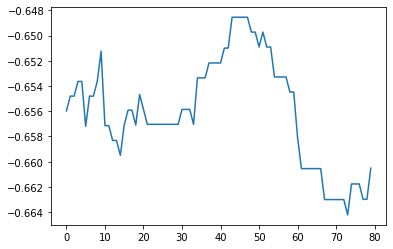

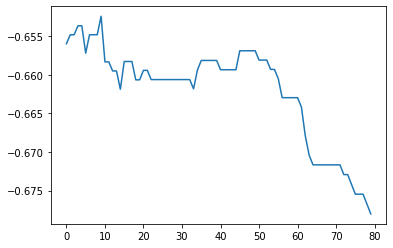

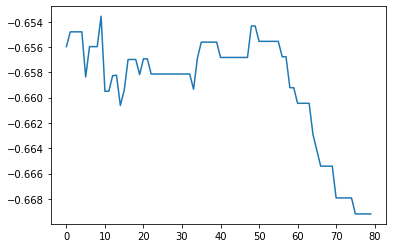

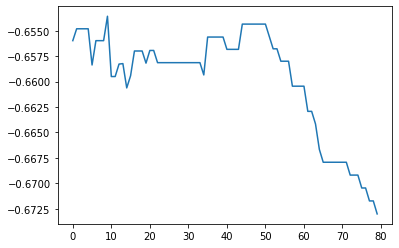

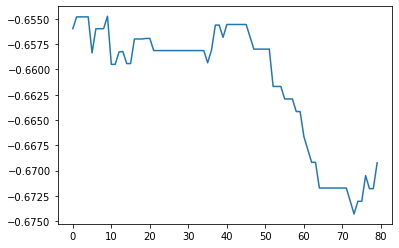

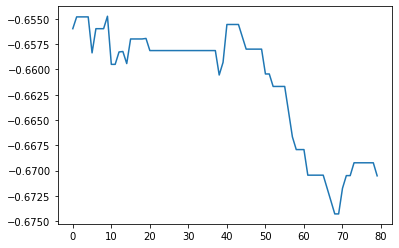

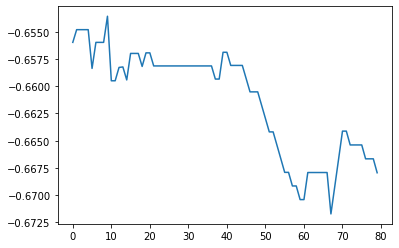

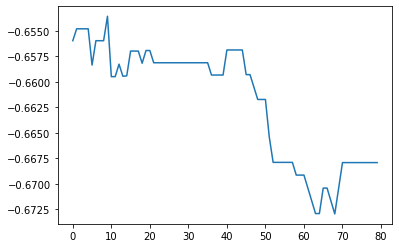

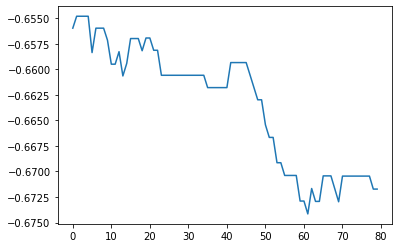

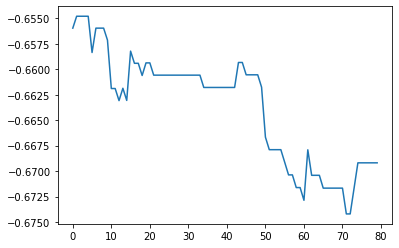

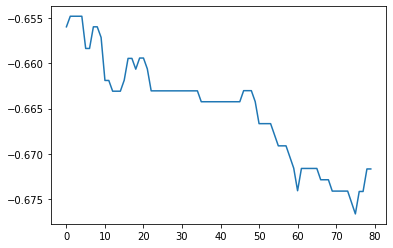

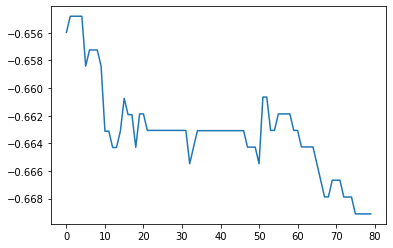

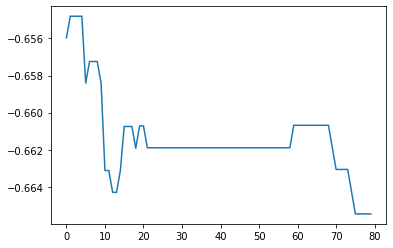

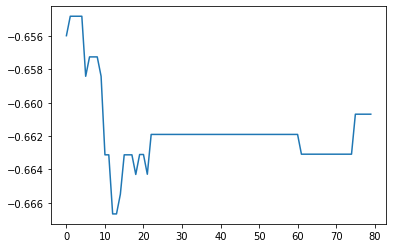

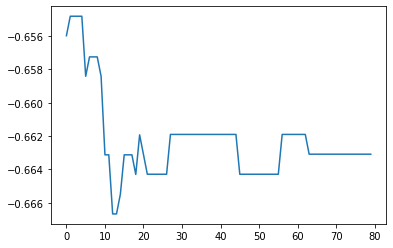

In [206]:
criterion = F1_loss_objective
# # fh = open("datasets/emotions/sglthresh_emotions_F1obj_micro_sigma_LabelPowerset.txt","wt")
# fh = open("datasets/emotions/sglthresh_emotions_F1obj_micro_sigma_myNetwork.txt","wt")

# criterion = torch.nn.BCELoss(reduction="mean")
# fh = open("datasets/emotions/sglthresh_emotions_BCEobj_micro_sigma.txt","wt")

learning_rate = 1e-3
num_epochs = 80
# fh.write("a,f1train,ptrain,rtrain,f1test,ptest,rtest\n")
metrics_list = []
scale_param_values_list = []

scale_list = range(1, 150, 10) # F1
# scale_list = range(1, 80, 5) # BCE

for sigma_value in scale_list:
    
    sigma_value = float(sigma_value)
    if sigma_value>1: sigma_value-=1.
    scale_param_values_list.append(sigma_value)
        
    print("sigma:", sigma_value)
    
    THRESHmodel = ThresholdModel(threshold_fn=threshold_fn, t=0.3, sigma=sigma_value, nb_classes=nb_classes)
    THRESHmodel = THRESHmodel.to(device, dtype=torch.float)
    # criterion = torch.nn.BCELoss(reduction="mean")

#     THRESHoptimizer = torch.optim.Adam([
#                 {'params': THRESHmodel.thresh}
#             ], lr=learning_rate)

    #     learn the thresholds and sigma:
    THRESHoptimizer = torch.optim.Adam([
                    {'params': THRESHmodel.thresh},
                    {'params': THRESHmodel.sigma, 'lr': 1e-2}
                ], lr=learning_rate)

    cumul_delta_thresh = torch.zeros(nb_classes,)
    delta_thresh = torch.zeros(nb_classes,)

    for el in THRESHmodel.parameters():
        PREC_learned_AT_thresholds = el.clone().detach().cpu()

    losses = []
    for epoch in range(num_epochs):

        debut = time.time()

        THRESHmodel.train()

        # Forward pass
        # inputs:  predictions_tensor
        outputs = THRESHmodel(pth_dev_probs)

    #     if epoch % 10 == 0:
    #         print(outputs[-1])
        loss = criterion(outputs, pth_dev_gt)

        # Backward and optimize
        THRESHoptimizer.zero_grad()

        loss.backward()
    #     loss.mean().backward()
    #         loss.backward(at_batch_y)
        # loss.backward(torch.ones_like(loss))

        THRESHoptimizer.step()
        # THRESHmodel.clamp()
        losses.append(loss)

        duree_epoch = time.time() - debut

#         print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
#                .format(epoch+1, num_epochs, loss, duree_epoch))

        for el in THRESHmodel.parameters():
            learned_AT_thresholds = el.clone().detach().cpu()

        delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
        cumul_delta_thresh += delta_thresh
        PREC_learned_AT_thresholds = learned_AT_thresholds
#         if epoch % 10 == 0: print('threshs:', learned_AT_thresholds)
        # if torch.sum(delta_thresh) < 0.01: break

#     print('delta:', cumul_delta_thresh)
    plt.figure()
    plt.plot(losses)
    
    learned_AT_thresholds=THRESHmodel.thresh.clone().detach().cpu().numpy()
    dev_pred = dev_outputs_numpy>learned_AT_thresholds
    test_pred = test_outputs_numpy>learned_AT_thresholds
#     print("dev")
#     print_scores(y_dev_numpy, dev_pred)
#     # compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
#     print("test")
#     print_scores(y_test_numpy, test_pred)
    
    p2, r2, fscore2, support = precision_recall_fscore_support(y_dev_numpy, dev_pred, pos_label=1, average='micro')
#     p3, r3, fscore3, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='macro')
    p2te, r2te, fscore2te, _ = precision_recall_fscore_support(y_test_numpy, test_pred, pos_label=1, average='micro')

#     fh.write("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f\n"%(sigma_value, 100.*fscore2, 100.*p2, 100.*r2, 
#                                                    100.*fscore2te, 100.*p2te, 100.*r2te))
    metrics_list.append([p2, r2, fscore2, p2te, r2te, fscore2te])
    
# fh.close()

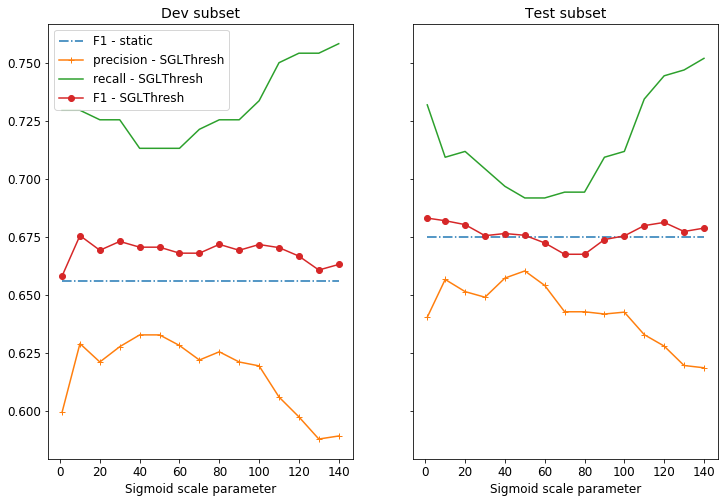

In [207]:
def plot_influence_de_a(scale_param_values, ptest, rtest, f1test, peval, reval, f1eval):
    
    fontsize=12
    plotEval = True
    learnThresholdsOnly=True
    
    if plotEval:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,8))
        if learnThresholdsOnly:
            bname = "exp/%s/BR_SVM_influence_sigma_objective_F1_learnThresholdsOnly_DEV_EVAL"%(dataset)
        else:
            bname = "exp/%s/BR_SVM_influence_sigma_objective_F1_learnThresholdsAndSigma_DEV_EVAL"%(dataset)
        output_fig_path_PNG= bname + ".png"
        output_fig_path_EPS=bname + ".eps"
    else:
        fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(12,8))
        if learnThresholdsOnly:
            bname = "exp/%s/BR_SVM_influence_sigma_objective_F1_learnThresholdsOnly_DEV"%(dataset)
        else:
            bname = "exp/%s/BR_SVM_influence_sigma_objective_F1_learnThresholdsAndSigma_DEV"%(dataset)
        output_fig_path_PNG= bname + ".png"
        output_fig_path_EPS=bname + ".eps"
        
    xlimsup=140
#     xlimsup=30
    
    ax1.plot([1, xlimsup], [0.656, 0.656], '-.', label='F1 - static')
    ax1.plot(scale_param_values, ptest, '-+', label='precision - SGLThresh')
    ax1.plot(scale_param_values, rtest, label='recall - SGLThresh')
    ax1.plot(scale_param_values, f1test, '-o', label='F1 - SGLThresh')
#     ax1.plot([1, xlimsup], [0.5659, 0.5659], '-.', label='F1 - static')
#     ax1.plot([1, xlimsup], [0.6118, 0.6118], '--', label='F1 - numThresh')
#     ax1.plot([1, xlimsup], [0.6128, 0.6128], '--', label='F1 - numThresh')
    ax1.legend(fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.set_xlabel('Sigmoid scale parameter',fontsize=fontsize)
#     ax1.set_ylim([0.52, 0.66])
    ax1.set_title("Dev subset",fontsize=14)
    if plotEval:
        ax2.plot([1, xlimsup], [0.675, 0.675], '-.', label='F1 - static')
        ax2.plot(scale_param_values, peval, '-+', label='precision - SGLThresh')
        ax2.plot(scale_param_values, reval, '-', label='recall - SGLThresh')
        ax2.plot(scale_param_values, f1eval, '-o', label='F1 - SGLThresh')
    #     ax2.plot([1, xlimsup], [0.5698, 0.5698], '-.', label='F1 - static')
    #     ax2.plot([1, xlimsup], [0.6024, 0.6024], '--', label='F1 - numThresh')
    #     ax2.plot([1, xlimsup], [0.5828, 0.5828], '--', label='F1 - numThresh')
    #     ax2.legend(fontsize=fontsize)
        ax2.tick_params(axis='x', labelsize=fontsize)
        ax2.set_xlabel("Sigmoid scale parameter",fontsize=fontsize)
        ax2.set_title("Test subset",fontsize=14)
    #     plt.suptitle("BCE objective",fontsize=16)
    #     plt.suptitle("F1 objective",fontsize=16)
#     plt.savefig(output_fig_path_PNG)
#     plt.savefig(output_fig_path_EPS)

metrics_array = np.array(metrics_list)
scale_param_values = np.array(scale_param_values_list)
# scale_param_values = np.array(range(1, 80, 5))
plot_influence_de_a(scale_param_values, metrics_array[:,0], metrics_array[:,1], metrics_array[:,2], metrics_array[:,3], metrics_array[:,4], metrics_array[:,5])    

In [153]:
# metrics_list = np.array(metrics_list)
metrics_list.shape

(15, 6)

# NumThresh

In [210]:
from sgl_utils.opt import Adam
from sklearn import metrics

## utility function

In [211]:
def calculate_f1(y_true, output, thresholds, average):
    """Calculate F1 score.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    """
    if y_true.ndim == 3:
        (N, T, F) = y_true.shape
        y_true = y_true.reshape((N * T, F))
        output = output.reshape((N * T, F))

    classes_num = y_true.shape[-1]
    binarized_output = np.zeros_like(output)
#     print('class num:', classes_num)
    
    for k in range(classes_num):
        binarized_output[:, k] = (np.sign(output[:, k] - thresholds[k]) + 1) // 2

    if average == 'micro':
        return metrics.f1_score(y_true.flatten(), binarized_output.flatten())
    
    f1_array = []
    for k in range(classes_num):
        f1_array.append(metrics.f1_score(y_true[:, k], binarized_output[:, k]))

    if average == 'macro':
        return np.average(f1_array)
    elif average is None:
        return f1_array
    else:
        raise Exception('Incorrect argument!')


def calculate_at_gradient(y_true, output, thresholds, average):
    """Calculate gradient of thresholds numerically.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    Returns:
      grads: vector
    """
    f1 = calculate_f1(y_true, output, thresholds, average)
    classes_num = len(thresholds)
    
    delta = 0.01
    grads = []
#     print("calculate_at_gradient, f1:", f1)
    
    for k, threshold in enumerate(thresholds):
        new_thresholds = thresholds.copy()
        cnt = 0
        while cnt < 10:
            cnt += 1
            new_thresholds[k] += delta
            f1_new = calculate_f1(y_true, output, new_thresholds, average)
            if f1_new != f1:
                break

        grad = (f1_new - f1) / (delta * cnt)
        grads.append(grad)

    return grads


def optimize_at_with_gd(y_true, output, thresholds, average):
    """Optimize thresholds for AT.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    Returns:
      metric: float
      thresholds: vector
    """
    opt = Adam()
    opt.alpha = 1e-2
    metric = calculate_f1(y_true, output, thresholds, average)
    metric_asfo_epoch = [metric]
    for i in range(100):
        grads = calculate_at_gradient(y_true, output, thresholds, average)
#         if i==0: print("grads:", grads)
        grads = [-e for e in grads]
        thresholds = opt.GetNewParams(thresholds, grads)
        metric = calculate_f1(y_true, output, thresholds, average)
        if i%50==0:
            print('Iteration: {}, Score: {:.3f}, thresholds: {}'.format(
                i, metric, np.array(thresholds)))
        metric_asfo_epoch.append(metric)
        
    return metric, thresholds, metric_asfo_epoch


## numerical application

In [212]:
t=0.3
thresh = [t]*nb_classes

average = 'micro'

manual_thres_f1 = calculate_f1(y_dev_numpy, dev_outputs_numpy, thresholds=thresh, average=average)
# print_scores(y_test_numpy, test_pred)

# Optimize thresholds
# (auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_at_with_gd(y_train_numpy, train_outputs_numpy, 
#                                                                           thresh, average=average)
(auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_at_with_gd(y_dev_numpy, dev_outputs_numpy, 
                                                                          thresh, average=average)

print_thresholds(auto_thresholds, nb_classes)
# print("%.3f %.3f"%(manual_thres_f1*100, fscore2*100))

print('train manual_thres f1: {:.3f}'.format(manual_thres_f1))
print('train auto_thres f1: {:.3f}'.format(auto_thres_f1))


Iteration: 0, Score: 0.660, thresholds: [0.29000087 0.3099996  0.29000328 0.30999636 0.29000087 0.29000038]
Iteration: 50, Score: 0.662, thresholds: [0.29684134 0.32051178 0.29767932 0.35635746 0.27214182 0.28270726]
auto_thresholds 0.2971 0.3244 0.2966 0.3511 0.2858 0.2778 
train manual_thres f1: 0.656
train auto_thres f1: 0.661


(array([0.654, 0.656, 0.658, 0.66 , 0.662, 0.664, 0.666]),
 <a list of 7 Text yticklabel objects>)

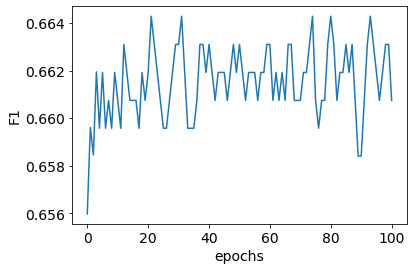

In [213]:
fontsize=14
plt.plot(metric_asfo_epoch)
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.savefig("datasets/emotions/emotions_F1_asof_epochs_myNetwork.png")

In [214]:
print_thresholds(auto_thresholds, nb_classes)
train_pred = train_outputs_numpy>auto_thresholds
dev_pred = dev_outputs_numpy>auto_thresholds
test_pred = test_outputs_numpy>auto_thresholds
print('train')
print_scores(y_train_numpy, train_pred)
# compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
print('dev')
print_scores(y_dev_numpy, dev_pred)
print('test')
print_scores(y_test_numpy, test_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)

auto_thresholds 0.2971 0.3244 0.2966 0.3511 0.2858 0.2778 
train
              precision    recall  f1-score   support

           0      0.697     0.864     0.772        88
           1      0.653     0.653     0.653        72
           2      0.712     0.952     0.815       104
           3      0.857     0.931     0.893        58
           4      0.758     0.770     0.764        61
           5      0.625     0.915     0.743        82

   micro avg      0.704     0.856     0.773       465
   macro avg      0.717     0.847     0.773       465
weighted avg      0.709     0.856     0.772       465
 samples avg      0.722     0.857     0.754       465

set acc: 0.372
dev
              precision    recall  f1-score   support

           0      0.426     0.742     0.541        31
           1      0.400     0.457     0.427        35
           2      0.704     0.891     0.786        64
           3      0.812     0.839     0.825        31
           4      0.438     0.618     0.512     

/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# plot learning curves

In [229]:
sgl_loss_dev_threshANDsigma_list = [-1*el.clone().detach().cpu().numpy() for el in losses]

In [234]:
sgl_loss_dev_thresh_list = [-1*el.clone().detach().cpu().numpy() for el in losses]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


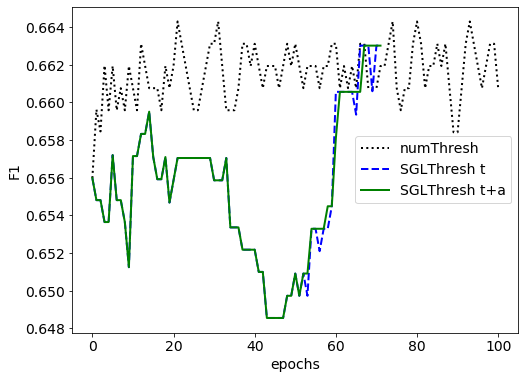

In [236]:
fontsize=14
linewidth=2
plt.figure(figsize=(8,6))
plt.plot(metric_asfo_epoch, ':k', linewidth=linewidth, label="numThresh")
plt.plot(sgl_loss_dev_thresh_list, '--b', linewidth=linewidth, label="SGLThresh t")
plt.plot(sgl_loss_dev_threshANDsigma_list, 'g', linewidth=linewidth, label="SGLThresh t+a")
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='center right')
plt.savefig("exp/emotions/emotions_SVM_F1_numThresh_SGL_DEV_asof_epochs.png")
plt.savefig("exp/emotions/emotions_SVM_F1_numThresh_SGL_DEV_asof_epochs.eps")

In [57]:
np.savez("exp/emotions/21_03_2020/emotions_F1_numThresh_SGL_DEV_asof_epochs.npz", 
         sgl_loss_dev_threshANDsigma_list=np.array(sgl_loss_dev_threshANDsigma_list), 
         metric_asfo_epoch = np.array(metric_asfo_epoch)
        )

# BR with SVM

In [68]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

In [112]:
clf = BinaryRelevance(
    classifier=SVC(kernel='linear', C=2., probability=True, random_state=123),
    require_dense=[True, True]
)

In [113]:
clf.fit(X_train_numpy, y_train_numpy)

BinaryRelevance(classifier=SVC(C=2.0, break_ties=False, cache_size=200,
                               class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3,
                               gamma='scale', kernel='linear', max_iter=-1,
                               probability=True, random_state=123,
                               shrinking=True, tol=0.001, verbose=False),
                require_dense=[True, True])

In [208]:
print('train')
train_pred = clf.predict(X_train_numpy)
print_scores(y_train_numpy, train_pred)
# compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
print('dev')
dev_pred = clf.predict(X_dev_numpy)
print_scores(y_dev_numpy, dev_pred)
print('test')
test_pred = clf.predict(X_test_numpy)
print_scores(y_test_numpy, test_pred)

train
              precision    recall  f1-score   support

           0      0.824     0.795     0.809        88
           1      0.786     0.458     0.579        72
           2      0.824     0.856     0.840       104
           3      0.895     0.879     0.887        58
           4      0.897     0.574     0.700        61
           5      0.817     0.707     0.758        82

   micro avg      0.836     0.723     0.775       465
   macro avg      0.840     0.712     0.762       465
weighted avg      0.835     0.723     0.767       465
 samples avg      0.787     0.724     0.726       465

set acc: 0.433
dev
              precision    recall  f1-score   support

           0      0.474     0.581     0.522        31
           1      0.448     0.371     0.406        35
           2      0.778     0.766     0.772        64
           3      0.815     0.710     0.759        31
           4      0.538     0.412     0.467        34
           5      0.792     0.388     0.521        49

/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_

In [115]:
svm_train_prob = clf.predict_proba(X_train_numpy)
svm_dev_prob = clf.predict_proba(X_dev_numpy)
svm_test_prob = clf.predict_proba(X_test_numpy)

svm_train_prob = svm_train_prob.toarray()
svm_dev_prob = svm_dev_prob.toarray()
svm_test_prob = svm_test_prob.toarray()
svm_train_prob.shape, svm_dev_prob.shape, svm_test_prob.shape

((261, 6), (130, 6), (202, 6))

/home/pellegri/tools/miniconda3/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 7 Text yticklabel objects>)

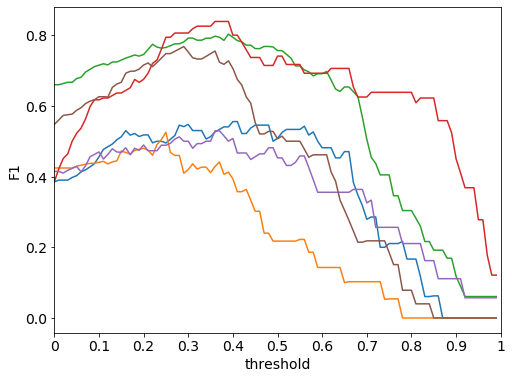

In [116]:
ps, rs, f1s = [], [], []

for static_thresh in range(0, 100):
    static_thresh /= 100.
    train_pred = svm_train_prob>static_thresh
    dev_pred = svm_dev_prob>static_thresh
    test_pred = svm_test_prob>static_thresh

    # p, r, f1 = micro_prec_rec_fscore(y_dev_numpy, dev_pred)
    p, r, f1 = micro_prec_rec_fscore_class(y_dev_numpy, dev_pred)
    ps.append(p)
    rs.append(r)
    f1s.append(f1)

f1s = np.array(f1s)

fontsize=14
linewidth=2
plt.figure(figsize=(8,6))
for ind in range(f1s[0].shape[0]):
    plt.plot(f1s[:,ind], label='%d'%ind)

# plt.plot([23, 23], [0, 0.6], '-k')
plt.xlabel("threshold", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xlim([0,100])
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.legend(fontsize=fontsize, loc='upper right')
# plt.savefig("exp/emotions/emotions_F1_DEV_asof_threshold.png")
# plt.savefig("exp/emotions/emotions_F1_DEV_asof_threshold.eps")

In [117]:
np.savez("exp/emotions/SVM_BR_probs.npz",
         svm_train_prob=svm_train_prob,
         svm_dev_prob = svm_dev_prob,
        svm_test_prob = svm_test_prob
        )